In [1]:
pip install --user yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
# pip install pandas-datareader

In [3]:
start='2018-7-11'
end  ='2020-8-31'
# data_source = 'yahoo'

In [4]:
# from pandas_datareader import data
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### VOO example

In [5]:
VOO = yf.Ticker("VOO")
VOO = VOO.history(start=start, end=end)
VOO.head(4)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-07-11,244.58,245.36,244.03,244.38,2335100,0.0,0
2018-07-12,245.60,246.56,244.97,246.47,2874000,0.0,0
2018-07-13,246.39,247.04,245.91,246.68,1814500,0.0,0
2018-07-16,246.78,246.89,246.08,246.53,993500,0.0,0


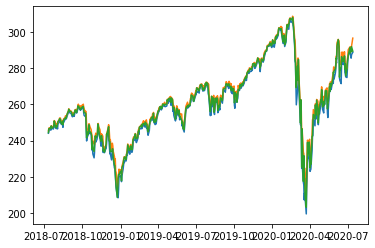

In [6]:
plt.plot(VOO['Low'])
plt.plot(VOO['High'])
plt.plot(VOO['Close'])

# EDA

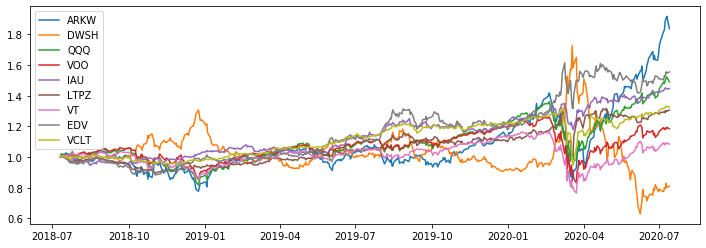

In [7]:
list_of_ETF_names =         ['ARKW','DWSH','QQQ','VOO','IAU','LTPZ', 'VT','EDV','VCLT','EMLC','DBC','UVXY']
asset_fraction_RayDalio =   [   0.0,   0.0,  0.0,  0.0, 0.05,   0.2, 0.35,  0.2, 0.075, 0.075, 0.05,   0.0]
asset_fraction_Preliminary= [   1.0,   1.0,  1.0,  1.0,  1.0,   1.0,  0.0,  0.0,   0.0,   0.0,  0.0,   0.0]
asset_fraction_Preliminary = np.array(asset_fraction_Preliminary)/np.sum(asset_fraction_Preliminary)

list_of_ETFs = []

for ETF_names in list_of_ETF_names:
  tmp = yf.Ticker(ETF_names)
  list_of_ETFs.append(tmp.history(start=start, end=end).copy())

plt.figure(figsize=(12,4))
for item in list_of_ETFs[:-3]:
  plt.plot(item['Close']/item['Close'][0])
plt.legend(list_of_ETF_names)

In [8]:
def get_index(ETFname):
  for i,name in enumerate(list_of_ETF_names):
    if name==ETFname:
      return i

### TEST: Prilimirary portfolio vs Raydalio All weather

In [9]:
def get_portfolio(asset_fraction):

  portfolio = pd.DataFrame(list_of_ETFs[0]['Close'].copy())
  portfolio['Close'] = 10000.0
  
  asset_value = portfolio.iloc[0]['Close']
  for iDate in range(1,len(portfolio['Close'])):
    asset_value = portfolio.iloc[iDate-1]['Close']
    asset_value_change = 0
    for iETF,ETF in enumerate(list_of_ETFs):
      changes_ratio = ETF.iloc[iDate]['Close']/ETF.iloc[iDate-1]['Close'] - 1.0
      asset_value_change = asset_value_change + asset_value*asset_fraction[iETF]*changes_ratio
      asset_value_change = asset_value_change + asset_value*asset_fraction[iETF]/ETF.iloc[iDate]['Close']*ETF.iloc[iDate]['Dividends']
    asset_value = asset_value + asset_value_change
    portfolio.iloc[iDate]['Close'] = asset_value

  return portfolio

In [10]:
portfolio_RayDalio = get_portfolio(asset_fraction_RayDalio)
portfolio_Preliminary = get_portfolio(asset_fraction_Preliminary)

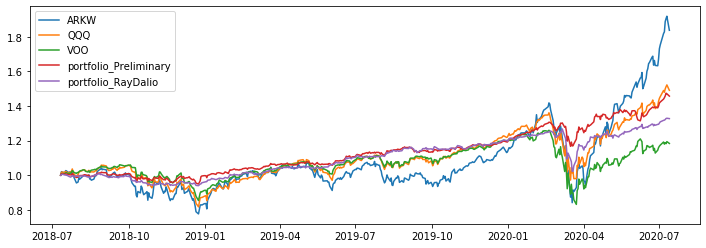

In [11]:
plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('ARKW')]
plt.plot(item['Close']/item['Close'][0])
item = list_of_ETFs[get_index('QQQ')]
plt.plot(item['Close']/item['Close'][0])
item = list_of_ETFs[get_index('VOO')]
plt.plot(item['Close']/item['Close'][0])

plt.plot(portfolio_Preliminary['Close']/portfolio_Preliminary['Close'][0])
plt.plot(portfolio_RayDalio['Close']/portfolio_RayDalio['Close'][0])

plt.legend([list_of_ETF_names[get_index('ARKW')],
            list_of_ETF_names[get_index('QQQ')],
            list_of_ETF_names[get_index('VOO')],
            'portfolio_Preliminary',
            'portfolio_RayDalio'])

In [12]:
def get_linear_model(asset_hist):
  n_days = len(asset_hist)
  momentum = (asset_hist[-1]/asset_hist[0]-1.0)/n_days
  diff = asset_hist/asset_hist[0] - momentum*range(n_days)
  return momentum, diff


# performace_measure_duration = 60 ~ approximate 3 month
# tolarable volatility / momentum = 0.7

def get_portfolio_performance_based_on_linear_model(asset_fraction):
  asset_fraction_tmp = np.array(asset_fraction)
  asset_fraction_tmp = asset_fraction_tmp/np.sum(asset_fraction_tmp)
  portfolio = get_portfolio(asset_fraction_tmp)
  Momentum = []
  volatility = []
  for i in range(len(portfolio['Close'] -21)):
    tmp = portfolio['Close'][i:i+21]
    p, diff = get_linear_model(tmp)
    std = np.std(diff)
    Momentum.append(p)
    volatility.append(std)

  return np.array(Momentum) - 0.7*np.array(volatility)

In [13]:
# Exponential Moving Average (EMA)
s = 2.0 # smoothing param
d = 60  # averaging duration

def get_EMA(asset_hist):
  EMA = [np.mean(asset_hist[0:d])]
  for i in range(d,len(asset_hist)):
    EMA.append(asset_hist[i]*s/(1.0+d) + EMA[-1]*(1.0-s/(1.0+d)))
  
  return pd.Series(EMA,index=asset_hist.index[d-1:])

In [14]:
EMAs = {'ARKW':get_EMA(list_of_ETFs[get_index('ARKW')]['Close']),
        'QQQ' :get_EMA(list_of_ETFs[get_index('QQQ' )]['Close']),
        'VOO' :get_EMA(list_of_ETFs[get_index('VOO' )]['Close']),
        'Preliminary':get_EMA(portfolio_Preliminary['Close']),
        'RayDalio':get_EMA(portfolio_RayDalio['Close'])}

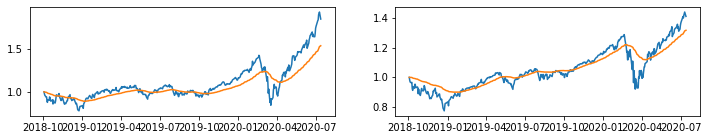

In [15]:
plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(list_of_ETFs[get_index('ARKW')]['Close'][d-1:]/list_of_ETFs[get_index('ARKW')]['Close'][d-1])
plt.plot(EMAs['ARKW']/EMAs['ARKW'][0])

plt.subplot(1,2,2)
plt.plot(list_of_ETFs[get_index('QQQ')]['Close'][d-1:]/list_of_ETFs[get_index('QQQ')]['Close'][d-1])
plt.plot(EMAs['QQQ']/EMAs['QQQ'][0])

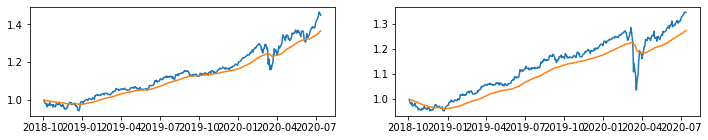

In [16]:
plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(portfolio_Preliminary['Close'][d-1:]/portfolio_Preliminary['Close'][d-1])
plt.plot(EMAs['Preliminary']/EMAs['Preliminary'][0])

plt.subplot(1,2,2)
plt.plot(portfolio_RayDalio['Close'][d-1:]/portfolio_RayDalio['Close'][d-1])
plt.plot(EMAs['RayDalio']/EMAs['RayDalio'][0])

In [17]:
# performace measure similar to Sharpe Ratio
# measure = normalized gain  / ( normalzied std + epsilon)
epsilon = 0.003  # fractional tolerable volatility
dd = 100 # performance measure duration 

def get_performance_based_on_EMA(asset_hist):
  EMA = get_EMA(asset_hist)
  DIFF = asset_hist[d-1:]/EMA - 1.0
  performance = []
  for i in range(len(EMA)-dd):
    performance.append( (asset_hist[d-1+i+dd]/asset_hist[d-1+i]-1.0) / (np.std(DIFF[i:i+dd])+epsilon) )
  return np.mean(performance)/(np.std(performance)+epsilon)

In [18]:
print('ARKW performace:',  get_performance_based_on_EMA(list_of_ETFs[get_index('ARKW')]['Close']) )
print('QQQ  performace:',  get_performance_based_on_EMA(list_of_ETFs[get_index('QQQ') ]['Close']) )
print('VOO  performace:',  get_performance_based_on_EMA(list_of_ETFs[get_index('VOO') ]['Close']) )
print('RayDalio performace:',  get_performance_based_on_EMA(portfolio_RayDalio['Close']))
print('Preliminary performace:',  get_performance_based_on_EMA(portfolio_Preliminary['Close']))

ARKW performace: 0.801533700065029
QQQ  performace: 1.0953715577385736
VOO  performace: 0.7872114125130307
RayDalio performace: 1.640643201820218
Preliminary performace: 3.2275604427003697


### Optimize portfolio: 

In [19]:
from scipy import optimize
from copy import deepcopy as copy

In [20]:
def obj(asset_fraction):
  asset_fraction_tmp = np.array(asset_fraction)
  asset_fraction_tmp = asset_fraction_tmp/np.sum(asset_fraction_tmp)
  portfolio = get_portfolio(asset_fraction_tmp)
  performance = get_performance_based_on_EMA(portfolio['Close'])
  return -performance

In [21]:
list_of_ETF_names

['ARKW',
 'DWSH',
 'QQQ',
 'VOO',
 'IAU',
 'LTPZ',
 'VT',
 'EDV',
 'VCLT',
 'EMLC',
 'DBC',
 'UVXY']

In [22]:
bounds = [(0.1,1.0),  #ARKW
          (0.1,1.0),  #DWSGH
          (0.1,1.0),  #QQQ
          (0.1,1.0),  #VOO
          (0.1,1.0),  #IAU
          (0.0,0.5),  #LTPZ
          (0.0,0.5),  #VT
          (0.0,0.5),  #EDV  Vanguard Extended Duration Treasury Zero-Coupon Bond ETF
          (0.0,0.5),  #VCLT Vanguard Long-Term Corporate Bond
          (0.0,0.5),  #EMLC Emerging market Gov Bond denominated in local currencies
          (0.0,0.5),  #DBC  Invesco Commodity Index
          (0.0,0.5),  #UVXY 2x VIX
          ]

In [ ]:
result = optimize.differential_evolution(obj,bounds,disp=True,popsize=8,workers=8)

/home/kilean/anaconda3/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


differential_evolution step 1: f(x)= -3.91125
differential_evolution step 2: f(x)= -3.91125
differential_evolution step 3: f(x)= -3.99746
differential_evolution step 4: f(x)= -3.99746
differential_evolution step 5: f(x)= -4.04918
differential_evolution step 6: f(x)= -4.04918
differential_evolution step 7: f(x)= -4.04918
differential_evolution step 8: f(x)= -4.04918
differential_evolution step 9: f(x)= -4.04918
differential_evolution step 10: f(x)= -4.07082
differential_evolution step 11: f(x)= -4.07082
differential_evolution step 12: f(x)= -4.07082
differential_evolution step 13: f(x)= -4.07082
differential_evolution step 14: f(x)= -4.07082
differential_evolution step 15: f(x)= -4.07082
differential_evolution step 16: f(x)= -4.07082
differential_evolution step 17: f(x)= -4.07082
differential_evolution step 18: f(x)= -4.07082
differential_evolution step 19: f(x)= -4.07082
differential_evolution step 20: f(x)= -4.07082


In [ ]:
# result

In [ ]:
asset_fraction = result.x/np.sum(result.x)

# asset_fraction = [0.17563657090399173, #ARKW
#                   0.021116428299677012,#DWSH
#                   0.21237443524263142, #QQQ
#                   0.0,                 #VOO
#                   0.0850017351959145,  #IAU
#                   0.0,                 #LTPZ
#                   0.17284503255176442, #VT
#                   0.250063043483558,   #EDV
#                   0.0,                 #VCLT
#                   0.051033434882044086,#EMLC
#                   0.0,                 #DBC
#                   0.03192931944041891  #UVXY
#                  ]

np.sum(asset_fraction)

In [ ]:
portfolio = get_portfolio(asset_fraction)

In [ ]:
plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('ARKW')]
plt.plot(item['Close']/item['Close'][0])
item = list_of_ETFs[get_index('QQQ')]
plt.plot(item['Close']/item['Close'][0])
item = list_of_ETFs[get_index('VOO')]
plt.plot(item['Close']/item['Close'][0])

plt.plot(portfolio_Preliminary['Close']/portfolio_Preliminary['Close'][0])
plt.plot(portfolio_RayDalio['Close']/portfolio_RayDalio['Close'][0])
plt.plot(portfolio['Close']/portfolio['Close'][0])

plt.legend([list_of_ETF_names[get_index('ARKW')],
            list_of_ETF_names[get_index('QQQ')],
            list_of_ETF_names[get_index('VOO')],
            'portfolio_Preliminary',
            'portfolio_RayDalio',
            'portfolio'])

In [ ]:
d_from = 250

plt.figure(figsize=(12,4))
item = list_of_ETFs[get_index('ARKW')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])
item = list_of_ETFs[get_index('QQQ')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])
item = list_of_ETFs[get_index('VOO')]
plt.plot(item['Close'][d_from:]/item['Close'][d_from])

plt.plot(portfolio_Preliminary['Close'][d_from:]/portfolio_Preliminary['Close'][d_from])
plt.plot(portfolio_RayDalio['Close'][d_from:]/portfolio_RayDalio['Close'][d_from])
plt.plot(portfolio['Close'][d_from:]/portfolio['Close'][d_from])

plt.legend([list_of_ETF_names[get_index('ARKW')],
            list_of_ETF_names[get_index('QQQ')],
            list_of_ETF_names[get_index('VOO')],
            'portfolio_Preliminary',
            'portfolio_RayDalio',
            'portfolio'])

In [ ]:
plt.figure(figsize=(12,2))
plt.subplot(1,2,1)
plt.plot(portfolio_Preliminary['Close'][d-1:]/portfolio_Preliminary['Close'][d-1])
plt.plot(EMAs['Preliminary']/EMAs['Preliminary'][0])

EMAs['portfolio']=get_EMA(portfolio['Close'])
plt.subplot(1,2,2)
plt.plot(portfolio['Close'][d-1:]/portfolio['Close'][d-1])
plt.plot(EMAs['portfolio']/EMAs['portfolio'][0])

In [ ]:
for i,ETFname in enumerate(list_of_ETF_names):
    print(ETFname,asset_fraction[i])

# From ratio to number of shares

In [ ]:
prices = []
for ETF in list_of_ETFs:
    prices.append(ETF['Close'][-1])

In [ ]:
len(list_of_ETFs)

In [ ]:
def get_portfolio_shares(asset_Value,asset_fraction,prices):
    shares = {}
    for i,ETFname in enumerate(list_of_ETF_names):
        shares[ETFname]=asset_Value*asset_fraction[i]/prices[i]
    return shares

In [ ]:
shares = get_portfolio_shares(20000,asset_fraction,prices)
shares